In [1]:
import pandas as pd
import numpy as np
import datetime
import optbinning.binning as ob
from optbinning import metrics
from optbinning import OptimalBinning

z = pd.read_csv(r"C:\Users\gromo\OneDrive\Documents\transactions_diy.csv")

# загружаем датасет Продажи

(CVXPY) Nov 22 05:08:16 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 22 05:08:16 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
# смотрим датасет

z

,TrDte,BCode,ClientID,Item,ItemGroup,Quantity,Amount
0,01.09.2017,code000000001,client13166,sku8444,Скобяные изделия,1,29
1,01.09.2017,code000000001,client13166,sku12545,Оборудование для сада и дачи,1,329
2,01.09.2017,code000000001,client13166,sku3391,Инструменты,1,169
3,01.09.2017,code000000001,client13166,sku20444,Инструменты,2,578
4,01.09.2017,code000000002,client1239,sku29959,Скобяные изделия,1,329
...,...,...,...,...,...,...,...
1008683,31.10.2019,code000290228,client25258,sku5837,Скобяные изделия,1,89
1008684,31.10.2019,code000290228,client25258,sku26161,Стойматериалы,2,598
1008685,31.10.2019,code000290228,client25258,sku20658,Сантехника,1,159
1008686,31.10.2019,code000290229,client22472,sku16069,Столярные изделия,1,85


In [3]:
# смотрим какие типы данных

z.dtypes

TrDte        object
BCode        object
ClientID     object
Item         object
ItemGroup    object
Quantity      int64
Amount        int64
dtype: object

In [4]:
# замечаем, что TrDte - object


In [5]:
z['Month'] = z['TrDte']
z['Month'] = pd.to_datetime(z['Month'], dayfirst=True)
z['Month'] = z['Month'].dt.month

z['Year'] = z['TrDte']
z['Year'] = pd.to_datetime(z['Year'], dayfirst=True)
z['Year'] = z['Year'].dt.year

z['TrDte'] = pd.to_datetime(z['TrDte'], dayfirst=True)


In [6]:
z1 = z # Визиты
z1['sum_amount'] = z1.groupby(['ClientID', 'TrDte', 'Item', 'ItemGroup'])['Amount'].transform('sum')
z1['sum_quantity'] = z1.groupby(['ClientID', 'TrDte', 'Item', 'ItemGroup'])['Quantity'].transform('sum')
z1 = z1.groupby(['ClientID', 'TrDte', 'Item', 'ItemGroup']).agg({'Amount': "sum", 'Quantity': "sum"}).reset_index()

z2 = z1 # Профиль клиента
z2['act_date'] = '10.01.2019'
z2['act_date2'] = '01.10.2019'
z2 = z2[z2['TrDte'] < z2['act_date']] 
z2['M'] = z2.groupby(['ClientID'])['Amount'].transform('sum')
z2['F'] = z2.groupby(['ClientID'])['TrDte'].transform('count')
z2['last_date'] = z2.groupby(['ClientID'])['TrDte'].transform('max')
z2['R'] = pd.to_datetime(z2['last_date'], dayfirst=True) - pd.to_datetime(z2['act_date2'], dayfirst=True)
z2['R'] = z2['R'].dt.days
z2['R'] = z2['R'].abs() - 1
z2['variance_item'] = z2.groupby(['ClientID'])['Item'].transform('nunique') # 1
z2['variance_item_group'] = z2.groupby(['ClientID'])['ItemGroup'].transform('nunique') # 2
z2['for_last_date_amount'] = z2.groupby(['ClientID', 'TrDte'])['Amount'].transform('sum') # 3
z22 = z2
z22 = z22[z22['TrDte'] == z22['last_date']]
z22 = z22.drop_duplicates(subset=['ClientID'])
z22 = z22.drop(['TrDte', 'ItemGroup', 'Item', 'Amount', 'Quantity', 'act_date',
                'M', 'F', 'last_date', 'R', 'variance_item', 'variance_item_group',
                ], axis=1)
z22 = z22.rename(columns={'for_last_date_amount': 'last_date_amount'})
z2 = pd.merge(z2, z22, how='left', on=['ClientID'])
weekend_purchases = z2[z2['TrDte'].dt.dayofweek.isin([5, 6])]
weekend_purchases = weekend_purchases.drop_duplicates(subset=['ClientID', 'TrDte'])
unique_visits_per_customer = weekend_purchases.groupby('ClientID').agg({'TrDte': 'nunique'})
unique_visits_per_customer['weekdays_amount'] = unique_visits_per_customer['TrDte']
unique_visits_per_customer = unique_visits_per_customer.drop(['TrDte'], axis=1)
z2 = pd.merge(z2, unique_visits_per_customer, how='left', on=['ClientID'])
z2['weekdays_amount'] = z2['weekdays_amount'].fillna(0).astype(int) # 4


z2['max_amount'] = z2.groupby(['ClientID'])['Amount'].transform('max') # 5
z2['max_quantity'] = z2.groupby(['ClientID'])['Quantity'].transform('max') # 6

z2 = z2.drop_duplicates(subset=['ClientID'])

z3 = z1 # События
z3['1st_date'] = '01.10.2019'
z3['2nd_date'] = '01.11.2019'

z4 = z1 # Все клиенты
z4['ClientID1'] = z4['ClientID']
z4 = z4.drop_duplicates(subset='ClientID')
z4 = z4[['ClientID', 'ClientID1']]

z5 = z1 # Транзакции в период
z5['ClientID2'] = z5['ClientID']
z5['TrDte'] = pd.to_datetime(z5['TrDte'], dayfirst=True)
z5['1st_date'] = z3['1st_date']
z5['2nd_date'] = z3['2nd_date']
z5['1st_date'] = pd.to_datetime(z5['1st_date'], dayfirst=True)
z5['2nd_date'] = pd.to_datetime(z5['2nd_date'], dayfirst=True)
z5 = z5[(z5['1st_date'] <= z5['TrDte']) & (z5['TrDte'] < z5['2nd_date'])]

z6 = z5 # Клиенты с визитом в октябре 2019
z6 = z6.drop_duplicates(subset='ClientID')
z6 = z6[['ClientID', 'ClientID2']]

z7 = pd.merge(z4, z6, how='left', on=['ClientID']) # Слияние
z8 = z7 # слияние + событие (не переименовал нормально столбцы)
z8 = z8.rename(columns={'ClientID2': 'fact'})

z2 = pd.merge(z2, z8, how='left', on=['ClientID']) # профиль + событие
z2['fact'] = z2['fact'].notna() 
z2 = z2.drop(['TrDte', 'Item', 'ItemGroup', 'Amount', 'Quantity', 'act_date'
              , 'last_date', 'for_last_date_amount',
              'act_date2_y', 'ClientID1',
              'act_date2_x'],
             axis=1)
z2

C:\Users\gromo\AppData\Local\Temp\ipykernel_14840\1794181004.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z2['M'] = z2.groupby(['ClientID'])['Amount'].transform('sum')
C:\Users\gromo\AppData\Local\Temp\ipykernel_14840\1794181004.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z2['F'] = z2.groupby(['ClientID'])['TrDte'].transform('count')
C:\Users\gromo\AppData\Local\Temp\ipykernel_14840\1794181004.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,ClientID,M,F,R,variance_item,variance_item_group,last_date_amount,weekdays_amount,max_amount,max_quantity,fact
0,client1,2273,4,616,4,2,2273,0,1535,5,False
1,client10,4757,3,56,3,1,4757,0,4599,1,False
2,client100,7299,1,145,1,1,7299,0,7299,1,True
3,client1000,36495,36,16,31,5,4703,5,3534,70,True
4,client10000,8495,5,425,5,1,8495,0,5999,1,False
...,...,...,...,...,...,...,...,...,...,...,...
41191,client9995,3677,3,303,3,1,1499,2,1999,1,False
41192,client9996,2499,1,425,1,1,2499,0,2499,1,False
41193,client9997,17691,3,27,3,2,15293,0,15293,20,False
41194,client9998,38666,80,2,37,13,598,9,4476,12,False


In [7]:
### Woe и IV
# Задание 2. Первый признак - самая дорогая покупка покупателя по одному продукту до даты актуальности
z9 = z2

opt_binner1 = OptimalBinning(min_bin_size=0.05, max_n_bins=5)


x1 = z9['max_amount']
x2 = z9['fact']


opt_binner1.fit_transform(x1, x2)

opt_binner1.status
binning_table1 = opt_binner1.binning_table
binning_table1.build()


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 419.50)",4072,0.098845,3710,362,0.088900,0.868713,0.055979,0.006785
1,"[419.50, 1211.50)",7915,0.192130,6873,1042,0.131649,0.428029,0.030650,0.003802
2,"[1211.50, 4033.00)",14566,0.353578,11953,2613,0.179390,0.062054,0.001335,0.000167
3,"[4033.00, 12058.00)",11803,0.286508,8945,2858,0.242142,-0.317457,0.031745,0.003952
4,"[12058.00, inf)",2840,0.068939,1941,899,0.316549,-0.688754,0.039649,0.004860
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,41196,1.000000,33422,7774,0.188708,,0.159358,0.019566


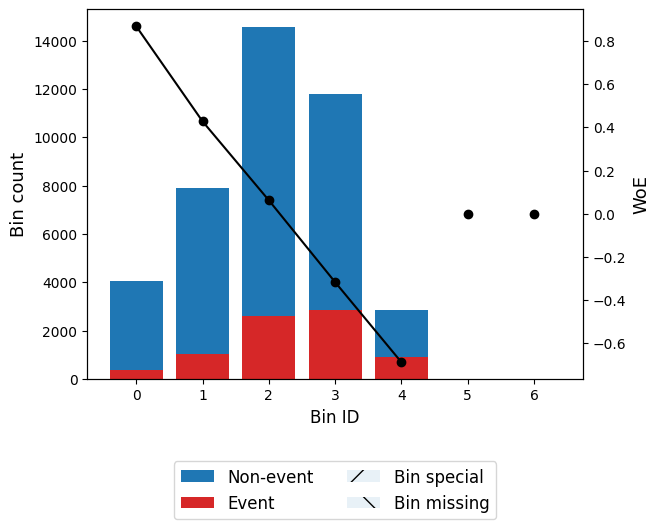

In [8]:
binning_table1.plot(metric="woe")

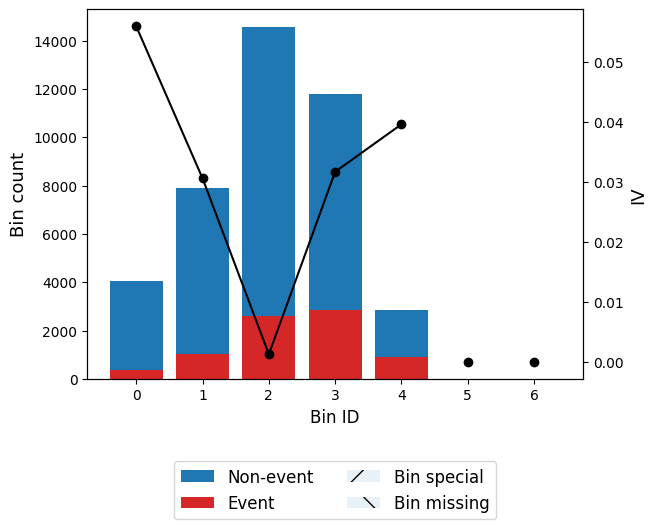

In [9]:
binning_table1.plot(metric="iv")

In [10]:
# Woe и IV
# Задание 2. Второй признак - самая большая покупка покупателя по одному продукту до даты актуальности
z10 = z2

opt_binner2 = OptimalBinning(min_bin_size=0.05, max_n_bins=5)


x2_1 = z9['max_quantity'].values
x2_2 = z9['fact'].values


opt_binner2.fit_transform(x2_1, x2_2)

opt_binner2.status
binning_table2 = opt_binner2.binning_table
binning_table2.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",7506,0.182202,6934,572,0.076206,1.036624,0.138793,0.016612
1,"[1.50, 2.50)",5611,0.136203,4978,633,0.112814,0.603884,0.040773,0.005021
2,"[2.50, 6.50)",13142,0.319012,10849,2293,0.174479,0.095782,0.002840,0.000355
3,"[6.50, 18.50)",9914,0.240654,7362,2552,0.257414,-0.398975,0.043089,0.005351
4,"[18.50, inf)",5023,0.121929,3299,1724,0.343221,-0.809457,0.099610,0.012122
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,41196,1.000000,33422,7774,0.188708,,0.325105,0.039460


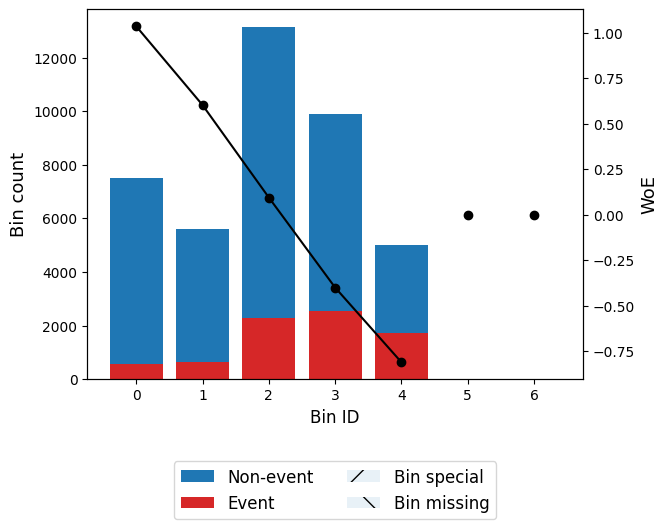

In [11]:
binning_table2.plot(metric="woe")

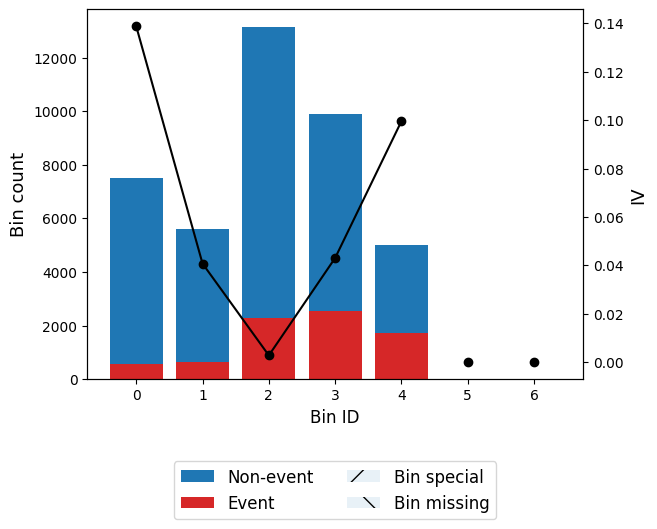

In [12]:
binning_table2.plot(metric="iv")